# Subjects Semi-Dependent Experiments

In [ ]:
#all subjects' samples shuffled and divided into an 80-20 train-test split

In [ ]:
## FOR GOOGLE COLLAB ONLY
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
## FOR GOOGLE COLLAB ONLY
#extract EEG & FNIRS data
#cp /content/drive/MyDrive/Data.zip .
#!unzip -qq Data.zip

In this notebook, we will apply EF-Net classifier to Hybrid EEG + fNIRS data with the data split in a Subject Semi-Dependent setting.

The current settings in this file will run the EF-Net model. (baseline_model==False). We also have the Deep Learning baselines here, that can be implemented using the 'baseline_model' boolean set to True, and further the 'resnet' boolean which indicates a resnet baseline to be used. If resnet==False, then the VGG baseline shall be implemented.
Deep learning parameters were set according to the table in the appendix of our published paper: [EF-Net: Mental State Recognition by Analyzing Multimodal EEG-fNIRS via CNN](https://doi.org/10.3390/s24061889). For more information on this code, please refer to this paper as well.

The dataset we have used is called: Simultaneous Acquisition of EEG and NIRS during Cognitive Tasks for
an Open Access Dataset,
    and is available here: https://doc.ml.tu-berlin.de/simultaneous_EEG_NIRS/. We are using Dataset C for classification.
    There is 72 fNIRS channels and 30 EEG channels. The dataset has 26 subjects in total. Each subject has data of 60 trials: which includes 3 sessions per subject, each session has 20 trials, each trial has 10 Word Generation tasks, and 10 Baseline tasks. This brings each subject to a total of 60 trials of either WG or BL tasks, performed in random order. Here we will further use those 60 trials to create 360 samples per subject, by using a sliding window technique across each trial.

In [3]:
import numpy as np
import tensorflow as tf
from data_preprocess import extract_subj_semidep
import hybrid_model_structures as models

### Inputs - enter here:

In [4]:
#INPUT

#subjects directory path
#The data should be extracted in the same directory as this script.
dir_path_f = "./FNIRS_data/FNIRS2/NIRS_01-26_MATLAB/"
dir_path_e="./EEG_data/EEG2/EEG_01-26_MATLAB/"



#######################
#Deep Learning settings:

baseline_model=False
resnet=False
if baseline_model:
    lr=0.0001
    EPOCHS=60
else:
    lr=0.01
    EPOCHS=60
BATCH_SIZE = 32
RANDOM_STATE=38


#### Extracting samples from the data

In [5]:
X_eeg, X_fnirs, Y = extract_subj_semidep(dir_path_e,dir_path_f,baseline_model)

Subject Count: 26
fnirs len 20107
eeg len 371283
Subject  1 is done. Length of X is now: 0 and length of Y is:  360
fnirs len 20219
eeg len 371416
Subject  2 is done. Length of X is now: 0 and length of Y is:  720
fnirs len 20269
eeg len 373808
Subject  3 is done. Length of X is now: 0 and length of Y is:  1080
fnirs len 20115
eeg len 371949
Subject  4 is done. Length of X is now: 0 and length of Y is:  1440
fnirs len 20237
eeg len 372647
Subject  5 is done. Length of X is now: 0 and length of Y is:  1800
fnirs len 20191
eeg len 371874
Subject  6 is done. Length of X is now: 0 and length of Y is:  2160
fnirs len 20145
eeg len 371449
Subject  7 is done. Length of X is now: 0 and length of Y is:  2520
fnirs len 20192
eeg len 372097
Subject  8 is done. Length of X is now: 0 and length of Y is:  2880
fnirs len 20241
eeg len 371618
Subject  9 is done. Length of X is now: 0 and length of Y is:  3240
fnirs len 20191
eeg len 371869
Subject  10 is done. Length of X is now: 0 and length of Y is:

We now have an array of 360 samples per subject, with a total of 9360 samples as shown across the train and test in output above. Each sample is a 5 second window from the task data, with one second of overlap with the previous sample.  
Secondly, we have an array Y made from the labels (y) array in session_markers from the dataset, and by appending the corresponding classes across the samples taken, we have 360 trial labels per subject in the Y array, totalling 9360 labels across all subjects' trials.

### Standardizing the data, and then splitting the train-test partitions

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
# Standardize our signals data
# Reshaping the data samples into 2D applying the scaling and then reshaping back
scaler = StandardScaler()

XeegS = scaler.fit_transform(X_eeg.reshape(-1, X_eeg.shape[-1])).reshape(X_eeg.shape)
XfnirsS = scaler.fit_transform(X_fnirs.reshape(-1, X_fnirs.shape[-1])).reshape(X_fnirs.shape)

#adjustment to labels to make compatible with binary_crossentropy
Y=Y[:,0]

print(XeegS.shape)
print(XfnirsS.shape)


(9360, 500, 30)
(9360, 25, 72)


In [8]:
#reshaping data into correct form for input into models.
if baseline_model:
  XeegS_3D=XeegS
  XfnirsS_3D=XfnirsS
else:
  #reshape into 2D and 1 channel data (3D samples list) for EF-Net.
  XeegS_3D=np.reshape(XeegS,(XeegS.shape[0],XeegS.shape[1],XeegS.shape[2],1))
  XfnirsS_3D=np.reshape(XfnirsS,(XfnirsS.shape[0],XfnirsS.shape[1],XfnirsS.shape[2],1))
XeegS_3D.shape

(9360, 500, 30, 1)

In [9]:
#Split all samples into training and testing splits
Xeeg_train, Xeeg_test, y_train, y_test = train_test_split(XeegS_3D, Y, test_size=0.2,random_state=RANDOM_STATE)
print(Xeeg_train.shape)

Xfnirs_train, Xfnirs_test, y_train2, y_test2 = train_test_split(XfnirsS_3D, Y, test_size=0.2, random_state=RANDOM_STATE)
print(Xfnirs_train.shape)

#print(np.all(y_train==y_train2))

(7488, 500, 30, 1)
(7488, 25, 72, 1)


In [10]:
print(Xeeg_train.shape, Xeeg_test.shape, y_train.shape, y_test.shape)

(7488, 500, 30, 1) (1872, 500, 30, 1) (7488,) (1872,)


### Applying a deep neural network to our data

### Combined Multiple Inputs DL Model - FNIRS + EEG

In [11]:
if baseline_model:
    hybridmodel= models.eeg_fnirs_vgg(Xeeg_train,Xfnirs_train, resnet)
else:
    hybridmodel=models.eeg_fnirs_cnn_v2()

In [12]:
hybridmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 30, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 494, 30, 32)          256       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 488, 30, 32)          7200      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 482, 30, 32)          7200      ['conv2d_1[0][0]']            
                                                                                            

In [13]:
from tensorflow.keras.optimizers import Adam

hybridmodel.compile(optimizer=Adam(learning_rate=lr),loss='binary_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [14]:
#save best model weights

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [15]:
hybridmodel.fit(x=[Xeeg_train, Xfnirs_train], y=y_train, epochs=EPOCHS,validation_data=([Xeeg_test, Xfnirs_test], y_test), batch_size=BATCH_SIZE, callbacks=[model_checkpoint_callback])

Epoch 1/60
233/234 [============================>.] - ETA: 0s - loss: 0.6875 - accuracy: 0.5459 - precision: 0.5467 - recall: 0.5231 - auc: 0.5650
Epoch 1: val_accuracy improved from -inf to 0.61111, saving model to ./tmp/checkpoint
234/234 [==============================] - 23s 34ms/step - loss: 0.6873 - accuracy: 0.5463 - precision: 0.5469 - recall: 0.5238 - auc: 0.5657 - val_loss: 0.6609 - val_accuracy: 0.6111 - val_precision: 0.6447 - val_recall: 0.5169 - val_auc: 0.6572
Epoch 2/60
233/234 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.6149 - precision: 0.5985 - recall: 0.6911 - auc: 0.6490
Epoch 2: val_accuracy improved from 0.61111 to 0.64476, saving model to ./tmp/checkpoint
234/234 [==============================] - 8s 35ms/step - loss: 0.6581 - accuracy: 0.6154 - precision: 0.5988 - recall: 0.6919 - auc: 0.6494 - val_loss: 0.6349 - val_accuracy: 0.6448 - val_precision: 0.6715 - val_recall: 0.5844 - val_auc: 0.7038
Epoch 3/60
234/234 [==================

In [16]:
hybridmodel.load_weights(checkpoint_filepath)

In [17]:
probabilities = hybridmodel.predict([Xeeg_test, Xfnirs_test])

59/59 [==============================] - 1s 8ms/step


In [18]:
y_preds= np.round(probabilities)

Text(17.25, 0.5, 'Actual label')

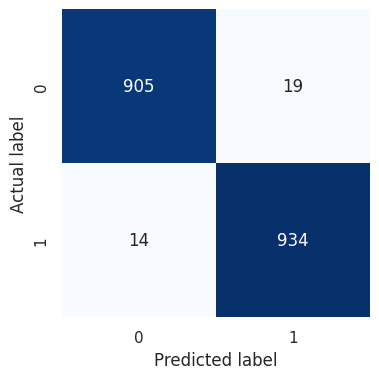

In [19]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()

plt.figure(figsize=(4,4))

mat = confusion_matrix(y_test, y_preds )
labels = [0,1]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [20]:
#FIX
loss,accuracy,precision,recall,AUC = hybridmodel.evaluate([Xeeg_test,Xfnirs_test], y_test)

59/59 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.9824 - precision: 0.9801 - recall: 0.9852 - auc: 0.9930


In [21]:
print("pretrained model=", baseline_model)
print("resnet=", resnet)
print("seed=",RANDOM_STATE)
print("lr=", lr)

pretrained model= False
resnet= False
seed= 38
lr= 0.01
